# Machine Learning for Credit Scoring

### Classification Models Applied and Compared (Supervised Learning)
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine (SVM)
- Stochastic Gradient Descent
- Extreme Gradient Boosting
- k-nearest neighbors
<br>
<br>
- Using **cross validation** to determine more accurate score which is **roc_auc**

### Content
1. Data Exploration
2. Data Clearance
3. Building and Selecting the Model
4. Performance of Model


### Goal
To create data mining model which helps to determine if a customer will be delinquent in upcoming 2 years after 90 days past.


### Given Variables
- **DelinquentMore90Days_2Yrs** Person experienced 90 days past due delinquency or worse **(Target)**

- **CreditBalanceVsCreditLimit**: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

- **Age** Age of borrower in years

- **MonthlyIncome**: Monthly income

- **DebtRatio**: Monthly debt payments, alimony,living costs divided by monthy gross income

- **LoansAndCreditLines**: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

- **Days30-59LateNo2Y**: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

- **Days60-89LateNo2Y**: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

- **Days90LateOrMore**: Number of times borrower has been 90 days or more past due.

- **RealEstateLoans**: Number of mortgage and real estate loans including home equity lines of credit

- **FamilyMembers**: Number of dependents in family excluding themselves (spouse, children etc.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data.csv',index_col=0)

## 1. Data Exploration

In [3]:
df.head()

,DelinquentMore90Days_2Yrs,CreditBalanceVsCreditLimit,Age,DebtRatio,MonthlyIncome,LoansAndCreditLines,Days30-59LateNo2Y,Days60-89LateNo2Y,Days90LateOrMore,RealEstateLoans,FamilyMembers
1,1,0.766127,45,0.802982,9120.0,13,2,0,0,6,2.0
2,0,0.957151,40,0.121876,2600.0,4,0,0,0,0,1.0
3,0,0.658180,38,0.085113,3042.0,2,1,0,1,0,0.0
4,0,0.233810,30,0.036050,3300.0,5,0,0,0,0,0.0
5,0,0.907239,49,0.024926,63588.0,7,1,0,0,1,0.0


In [4]:
df.describe()

,DelinquentMore90Days_2Yrs,CreditBalanceVsCreditLimit,Age,DebtRatio,MonthlyIncome,LoansAndCreditLines,Days30-59LateNo2Y,Days60-89LateNo2Y,Days90LateOrMore,RealEstateLoans,FamilyMembers
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,353.005076,6.670221e+03,8.452760,0.421033,0.240387,0.265973,1.018240,0.757222
std,0.249746,249.755371,14.771866,2037.818523,1.438467e+04,5.145951,4.192781,4.155179,4.169304,1.129771,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.366508,5.400000e+03,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.559046,63.000000,0.868254,8.249000e+03,11.000000,0.000000,0.000000,0.000000,2.000000,1.000000
max,1.000000,50708.000000,109.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,98.000000,54.000000,20.000000


- MonthlyIncome has 29731 (19.82%) and NumberOfDependents has 3924 (2.61%) missing data.
- In general all variables have outliers, it can be dealt by using boxplot, z-score, inter-quartile range, or by distribution graph/ data, where can be seen a clear outliers. Some outliers are reasonable, but it is not good to use while training ml model, since it can increase models' bias
- **DelinquentMore90Days_2Yrs** clearly our target variable has majority of values 0, since mean is ~0.0668, while all quartiles equal to 0
- **CreditBalanceVsCreditLimit** have a very high max, so in order to remove outlier, quartile 95% can be taken as a filter.
- **age** has value 0, which should no exist as default when person valid to have a credit is around 18.
- **DebtRatio** clearly has very big outlier, the priority to use quartile 97.5% to remove it.
- **MonthlyIncome** cannot drop the column, since 19.82% of data is missing, can be considered for removing rows or fill with median. Dropping NaN values better to apply, since variable is reasonable and filling with to many median variables can be misleading.
- **LoansAndCreditLines** can be considered to use graph and if clear where the distribution should end, filter it, otherwise use quartile 97.5% to remove outliers.
- Values for **Days30-59LateNo2Y**, **Days60-89LateNo2Y**, **Days90LateOrMore**	have the same outliers (98). It is not possible, since for a range 30-59 cannot dropping values 98 does not seems reasonable.
- **RealEstateLoans** use graph to find possible filter or can be considered to use quartile 97.5% to remove outliers.
- **FamilyMembers** missing values can be change to 0, since the mediana is 0 and missing value can mean a 0, which by this variable is reasonable. Use graph to explore if 20 could be outlier (but everything could be).

## 2. Data Clearance

In [5]:
# Graph function to not repeat the function for every variable #
def descriptive_graph(dataset,col_name):
    plt.hist([dataset[dataset["DelinquentMore90Days_2Yrs"]==1][col_name],
                 dataset[dataset["DelinquentMore90Days_2Yrs"]==0][col_name]], bins=30, stacked=True)
    plt.legend(labels=["DelinquentMore90Days_2Yrs-1","DelinquentMore90Days_2Yrs-0"])
    plt.title(col_name)
    return plt.show()

**CreditBalanceVsCreditLimit**

In [6]:
df["CreditBalanceVsCreditLimit"].value_counts()

0.000000    10878
1.000000    10256
1.000000       17
0.950100        8
0.713147        6
            ...  
0.486200        1
0.039377        1
0.030780        1
0.355181        1
0.168611        1
Name: CreditBalanceVsCreditLimit, Length: 125728, dtype: int64

In [7]:
df["CreditBalanceVsCreditLimit"].quantile([.95])

0.95    1.0
Name: CreditBalanceVsCreditLimit, dtype: float64

In [8]:
df = df.drop(df[df['CreditBalanceVsCreditLimit'] > 1].index)

**Age**

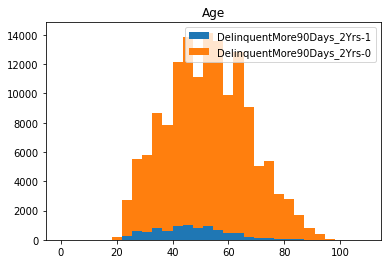

In [9]:
descriptive_graph(df,"Age")

In [10]:
df = df[df["Age"] > 18]

**DebtRatio**

In [11]:
df["DebtRatio"].quantile(0.975)

3497.0

In [12]:
df = df[df["DebtRatio"] < 3497]

**MonthlyIncome**

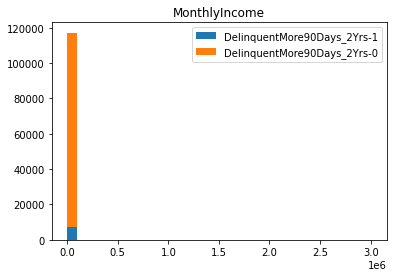

In [13]:
descriptive_graph(df,"MonthlyIncome")

In [14]:
df["MonthlyIncome"].quantile([.975])

0.975    18069.8
Name: MonthlyIncome, dtype: float64

Since this data has very big outliers, 2.5% can be removed to have better distribution. By filtering, na values will be dropped automatically

In [15]:
df = df[df["MonthlyIncome"] <= 18069.8]

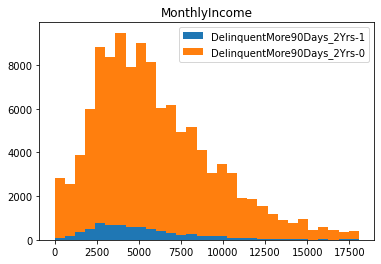

In [16]:
descriptive_graph(df,"MonthlyIncome")

**LoansAndCreditLines**

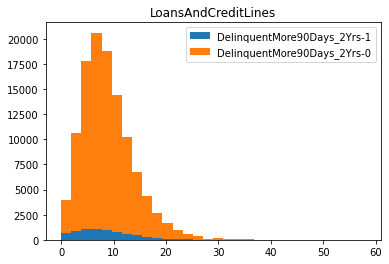

In [17]:
descriptive_graph(df,"LoansAndCreditLines")

By fiven graph, it is reasonable to filter from 28

In [18]:
df = df[df["LoansAndCreditLines"] <= 28]

**Days30-59LateNo2Y**

In [19]:
df["Days30-59LateNo2Y"].value_counts()

0     95702
1     12421
2      3457
3      1288
4       529
5       232
98      143
6        98
7        38
8        19
9         8
96        4
12        2
10        2
13        1
11        1
Name: Days30-59LateNo2Y, dtype: int64

In [20]:
df = df[df["Days30-59LateNo2Y"]<95]

**Days60-89LateNo2Y**

In [21]:
df["Days30-59LateNo2Y"].value_counts()

0     95702
1     12421
2      3457
3      1288
4       529
5       232
6        98
7        38
8        19
9         8
12        2
10        2
13        1
11        1
Name: Days30-59LateNo2Y, dtype: int64

**Days90LateOrMore**

In [22]:
df["Days90LateOrMore"].value_counts()

0     108161
1       3817
2       1025
3        433
4        186
5         74
6         45
7         19
9         12
8         10
10         7
11         2
13         2
14         2
15         1
12         1
17         1
Name: Days90LateOrMore, dtype: int64

**RealEstateLoans**

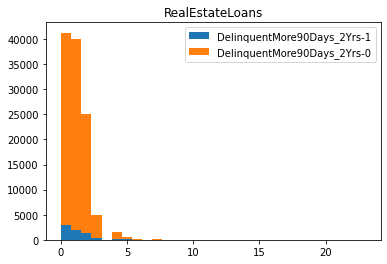

In [23]:
descriptive_graph(df,"RealEstateLoans")

In [24]:
df["RealEstateLoans"].quantile([.975])

0.975    3.0
Name: RealEstateLoans, dtype: float64

In [25]:
df = df[df["RealEstateLoans"] <= 3]

**FamilyMembers**

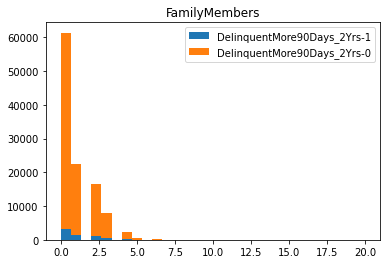

In [26]:
descriptive_graph(df,"FamilyMembers")

In [27]:
df["FamilyMembers"].quantile([.975])

0.975    4.0
Name: FamilyMembers, dtype: float64

In [28]:
df["FamilyMembers"].value_counts()

0.0     61393
1.0     22408
2.0     16443
3.0      7860
4.0      2339
5.0       598
6.0       131
7.0        45
8.0        19
9.0         4
10.0        4
13.0        1
20.0        1
Name: FamilyMembers, dtype: int64

13 and 20 will be removed since it can interupt the results with its high value, even it is a possible scenario

In [29]:
df = df[df["FamilyMembers"] <= 10]

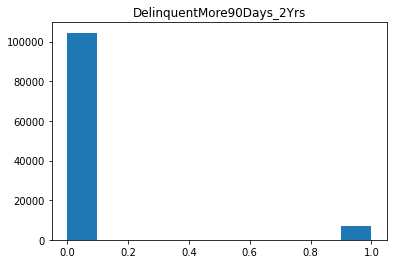

In [30]:
plt.hist(df["DelinquentMore90Days_2Yrs"])
plt.title("DelinquentMore90Days_2Yrs")
plt.show()

---
Clearly, classes are very inbalanced, so observations with value 0 overweights those who are with value 1. It can cause misleading results, so **accuracy** is not the best tool to use.
Missing a person who is delinquent can bring more issues than opposite prediction (predicting that a person will be delinquent, but it will not be).<br>
**Recall** = True Positive / (True Positive + False Negative) <br>
**Specificity** = True Negative / (True Negative + False Positive)<br>
**ROC and AUC** is a target measure to determine how good is discrimination
***
Resampling can be applied

## 3. Building and Selecting the Model

Splitting into 3 parts in order to check different model performances
- 70% train 
- 30% test

We do not need validation data, because we are using **cross validation**.

Since we do not have original test data, assuming test data is different dataset.

Models have different advantageous and disadvantage for instance:
#### Decision Tree
- Easy to Understand
- Easily Overfit
- Sensitive to changes in train data

#### Random Forest
- Can deal with overfitting
- Able to deal with large number of variables
- Takes longer to train

#### XGBoost
- Became very popular algorithm for classification (fast, effective, outliers do not have impact, good performance in Kaggle)
- Fastly handles big data sizes
- Harder to understand (a lot of hyperparameters)

Additionally, **Logistic Regression** is widely used for credit scoring, so by this case, all promising models will be tested in order to select the best

In [31]:
train, test = train_test_split(df,test_size=0.3)

In [32]:
X_train = train.drop(["DelinquentMore90Days_2Yrs"],axis=1)
Y_train = train["DelinquentMore90Days_2Yrs"]
X_test = test.drop(["DelinquentMore90Days_2Yrs"],axis=1)
Y_test = test["DelinquentMore90Days_2Yrs"]

### Given Models

In [33]:
classifiers ={
    "LogisticRegression" : LogisticRegression(max_iter = 1000),
    "RandomForestClassifier" : RandomForestClassifier(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": tree.DecisionTreeClassifier(),
    "Support Vector Machine": svm.SVC(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Extreme Gradient Boosting": XGBClassifier()
}

In order to have better accuracy of the model (priority to avoid frauds) **roc_auc** is a good measure

In [34]:
for key, clf in classifiers.items():
    start_time = time.time()
    score = cross_val_score(clf,X_train,Y_train,cv = 10,scoring='roc_auc')
    end_time = time.time() - start_time
    print(key,'score',round(score.mean(),2),'  Running Time', round(end_time,2))
    

LogisticRegression score 0.82   Running Time 20.34
RandomForestClassifier score 0.82   Running Time 132.03
KNearest score 0.55   Running Time 2.7
DecisionTreeClassifier score 0.59   Running Time 5.85
Support Vector Machine score 0.52   Running Time 227.03
Stochastic Gradient Descent score 0.64   Running Time 30.95
Extreme Gradient Boosting score 0.84   Running Time 30.38


Since model **Extreme Gradient Boosting** has the best roc_auc, it will be taken for the final prediction

 ## 4. Performance of Model

In [35]:
seleceted_model = XGBClassifier()
seleceted_model.fit(X_train,Y_train)
Y_test_predicted = seleceted_model.predict(X_test)

In [36]:
print('Accuracy: ',accuracy_score(Y_test, Y_test_predicted))

Accuracy:  0.94315934559837


In [37]:
pd.crosstab(np.array(Y_test), Y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,31177,194,31371
1,1703,300,2003
All,32880,494,33374


In general by percentage, a lot of values 1 are missed, because our classification data is inbalanced

#### ROC and AUC

In [38]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, seleceted_model.predict_proba(X_test)[:,1])

In [39]:
auc_score = auc(false_positive_rate, true_positive_rate)
print(auc_score)

0.8474827604310916


**Recall** = TP / (TP+FN) <br>
**Specificity** = TN / (TN+FP)

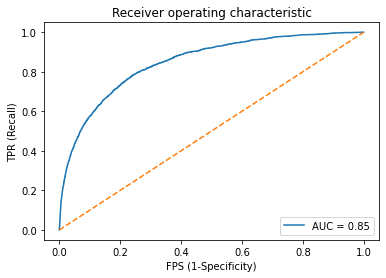

In [40]:
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate,true_positive_rate,label = 'AUC = %0.2f' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('TPR (Recall)')
plt.xlabel('FPS (1-Specificity)')
plt.show()

Usually a good model has AUC higher than 0.5, the bigger AUC plot is, the better model is. Since our models' AUC is 0.85 the classification model is good, but risky, depends how damageable is to miss a delinquent customer.

A model **can be improved** by applying:
- Grid Search to find the most optimal parameters (proper hyperparameters)
- Resampling to rebalance classification models
- Testing more classification models
- Try not to remove missing MonthlyIncome rows, but to apply mean, add additional column where 1 gives a value for rows where data is missing or even to predict missing values
- Remove variables based on Information Value
- Make interactive grouping of given data
- Standardize data to have normal distribution (reduce skewness). This is obvious that it would improve the model since our data is not normally distributed- Scale data to have similar ranges of values